
# Project: What can predict No-show 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction: data importation et exploration

> I would like to analyze the data from 100K medical appointments. This data is provided on Kaggle. The reason why patients did not show up attracts our attention here. 
Throughout this project, we are trying to predict the percentage of patients who didn't show by exploring the data and also the connections between variables Schedule Day/Appointment Day, SMS-received, Scholarship (financial aid to low-income families), hypertension and Age. This project has been inspired by the Udacity training "Data Analyst".

### Questions

1) Can the number of days between scheduling and appointment predict No Show?

2) Can Appointment Month be associated with No-Show?

3) Can Appointment Day of Week impact be associated with No-Show?

4) Can SMS-received predict No-show?

5) Is long waiting, SMS received, and No-Show interrelated?

6) Can Scholarship predict No-show?

7) Can Hypertension predict No-show?

8) Can Gender be associated with NoShow?

9) Can Age predict No-show?

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas_profiling
import statsmodels.api as sm
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling



### General Properties

#### Description of the variables
PatientId and AppointmentID serve only to identify the people and the appointment and are not predictor variables.
Gender might be useful to predict No-Show (people who didn't show up at the appointments).
ScheduleDay and AppointmentDay are the dates when the patient took the appointment and when the appointment happened or should have happened.
The Neighbourhood variable seems to be where the people lived, but it isn't really sure so I decided not to use this variable.
As mentioned, Scholarship is whether the family was receiving money due to their poverty.
We've got several problems like Diabetes,  Alcoholism, Handcap.
SMS-received is whether the family had received a SMS prior to the appointment.


In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
data=pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv')
data.head(5)




,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


There are a lot of Neighbourhood. And maybe I could make a map filled by neighborhood with No-Show mean in the future. With documentation, it might be interesting to study this variable.

In [3]:
data['Neighbourhood'].value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

In [4]:
'Age', 'Diabetes','Hypertension', 'Tuberculosis', 'Smokes',
                         'Alchoholism', 'Scholarship'

IndentationError: unexpected indent (<ipython-input-4-5a980f24cef3>, line 2)

### No null-data
There are 110'527 observations. Luckily no data seems to be missing.

In [5]:
#   types and look for instances of missing or possibly errant data.
data.shape

(110527, 14)

In the table below, we can see that no data is missing

In [6]:
data.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

The table below interprets the same fact, but it adds the data types. One potential problem might be that the variables "ScheduledDay" and "AppointmentDay" are in string. I would like to get AppointmentDay in datatype to test the month and the day of the week. Also I would like to get the difference between ScheduleDay and AppointmentDay. Luckily other variables like "Hypertension", "Diabetes" and "SMS-received" are all on int types, so no data transformation is needed for these variables.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Distribution of the variables
Age seems skewed to the right. There isn't a lot of difference in the variables "Diabetes", "Alcoholism" or "Handcap". Other variables like "SMS_received", "Scholarship" and "Hipertension" are easier to compare.

In [8]:
data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Age seems skewed to the right. There isn't a lot of difference in the variables "Alcoholism", or "Handcap". It's also the case for "Diabetes", but I would like to test the chronic diseases. Other variables like "SMS_received", "Scholarship" and "Hipertension" are easier to compare.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D1D313DC8>,
      dtype=object)

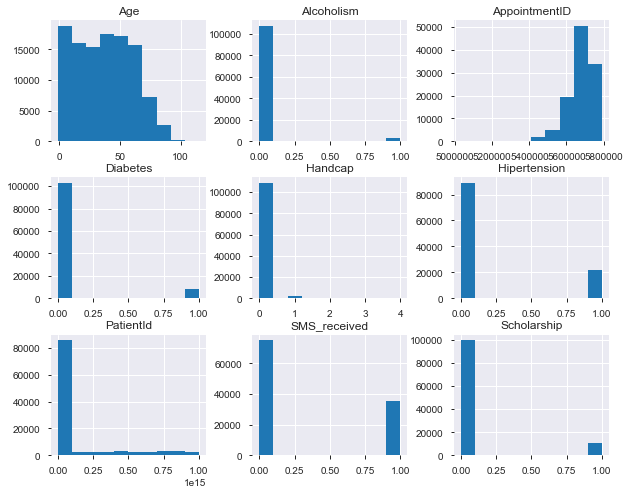

In [9]:
data.hist(figsize=(10,8))

### Data drop
As we won't use these variables. I decided to remove Appointment and Patient ID, Gender, Handicap, Neighbourhood, Diabetes, and Alcoholism from the dataset.
As discussed, there are some problems to interpret this data, and the variables I used were more easy to interpret.

In [10]:
data.drop(['PatientId','AppointmentID','Handcap','Neighbourhood','Alcoholism'],axis=1,inplace=True)
data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,No


### Three needs for the data analysis


1) It should be a description of days between Schedule Day and Appointment Day to see if waiting could be a predictor. To test that, I have to transform these two variables into DateTime, make the difference between both of them, and get this difference into the number of days as an int. 

2) No-show should only contain the boolean values True and False. And there should be a variable to count the Patients who showed up and the Patients who didn't show up. 

3) I wanted to know if Appointment Hours are different, so I could know if I had to do another test.

In [11]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
data.dtypes

Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Scholarship        int64
Hipertension       int64
Diabetes           int64
SMS_received       int64
No-show           object
dtype: object

#### No-show variable into boolean
First, I replace the values "Yes" and "No" by "True" and "False". As variable names usually don't have a Hyphen, and this could make comparisons more complicated, I renamed this column. After that, I observed that the values of "No-show" had changed, and this column has become "NoShow".
My next program assured that the variable was Boolean, and it is.
My next program was to create two variables: one for patients who showed up and one for patients who didn't show up. Then I tested a simple mean operation to see if this variable did work.

In [12]:
data['No-show'].replace({"Yes": True, "No": False},inplace=True)
data.rename(columns={"No-show": "NoShow"},inplace=True)
data[data['NoShow']==True].head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow
6,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,0,0,0,0,True
7,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,0,0,0,0,True
11,M,2016-04-26T08:44:12Z,2016-04-29T00:00:00Z,29,0,0,0,1,True
17,F,2016-04-28T09:28:57Z,2016-04-29T00:00:00Z,40,1,0,0,0,True
20,F,2016-04-27T07:51:14Z,2016-04-29T00:00:00Z,30,0,0,0,0,True


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 9 columns):
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
SMS_received      110527 non-null int64
NoShow            110527 non-null bool
dtypes: bool(1), int64(5), object(3)
memory usage: 6.9+ MB


In [14]:
didnt_show=data.NoShow==True
did_show=data.NoShow==False
data.NoShow.mean()*100

20.193255946510806

In [15]:
didnt_show.mean()*100

20.193255946510806

#### Difference of days
To get the difference between Schedule Day and Appointment Day, I first made two variables to get only the years, months, and days in these two variables (so I shorten in order not to have the hours, minutes, and seconds).
Then I turn these variables into DateTime to get the difference between "Schedule Day" and "Waiting Day".

In [16]:
data['Schedule']=data['ScheduledDay'].str[:10]
data['Appointment']=data['AppointmentDay'].str[:10]

In [17]:
data["Scheduled"] = pd.to_datetime(data["Schedule"])
data["AppointmentD"] = pd.to_datetime(data["Appointment"])
data['Waiting']=data['AppointmentD']-data['Scheduled']
data.head(10)

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow,Schedule,Appointment,Scheduled,AppointmentD,Waiting
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days
5,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,0,1,0,0,False,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days
6,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,0,0,0,0,True,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days
7,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,0,0,0,0,True,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days
8,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days
9,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,0,0,0,0,False,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days


The variable “Waiting” can’t serve as a mean. So I got this into the number of days. I had a message that this variable will be deprecated, but I don't know what would be the alternative solution.

In [18]:
data['WaitingDay'] = pd.DatetimeIndex(data['Waiting']).day -1
data.head(10)

C:\Users\AntoineM\Anaconda3\envs\investigate2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow,Schedule,Appointment,Scheduled,AppointmentD,Waiting,WaitingDay
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0
5,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,0,1,0,0,False,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days,2
6,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,0,0,0,0,True,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days,2
7,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,0,0,0,0,True,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days,2
8,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0
9,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,0,0,0,0,False,2016-04-27,2016-04-29,2016-04-27,2016-04-29,2 days,2


Finally, I could see the distribution of "Waiting Day". Lots of medical appointments are planned for the same day (at least 25%), and at least 25% have 10 days between the Scheduled Day and the Waiting Day. The median is on Three-Day waiting and the third quartile is on ten-day waiting.

In [19]:
data['WaitingDay'].describe()

count    110527.000000
mean          6.586409
std           8.252418
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max          30.000000
Name: WaitingDay, dtype: float64

### Appointment Hours are all the same
I also wanted to get the appointment hours to see if there was a No Show difference between the morning and the afternoon, for example. But when I took only the hours, I observed that this data set contains only "00" value. So the variable “AppointmentDay” mightn’t contain the appointment hours.

In [20]:
data['AppointmentDay'].str[-9:-7].value_counts()

00    110527
Name: AppointmentDay, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### 1) Can the number of days between scheduling and appointment predict No Show
The first variable I wanted to test on No Show was the day difference between the Scheduling and the Appointment. As I took the means, I saw there was a huge difference: people who did show waited 5.7 days on average, and people who didn't show up should have waited 10 days. But the histogram didn't make it so clear. So I took the mean of each number of waiting days between the scheduling and the appointment. There was a big difference when there was "0" days waiting, but no clear difference for the other values. It might be normal that an appointment taken the same day wasn't as much spoiled comparing to the other days.

In [21]:
print("Average number of waiting days when Patients showed:",data.WaitingDay[did_show].mean())
print("Average number of waiting days when Patients didn't show:",data.WaitingDay[didnt_show].mean())


Average number of waiting days when Patients showed: 5.699381008525304
Average number of waiting days when Patients didn't show: 10.09207401765312


We can see something very interesting here: lots of appointments are made the same day (more than 40'000 appointments), which concentrates the "did show" values on this value of the variable.

Text(0.5, 1.0, "Percentage of did show and didn't show per number of days waiting")

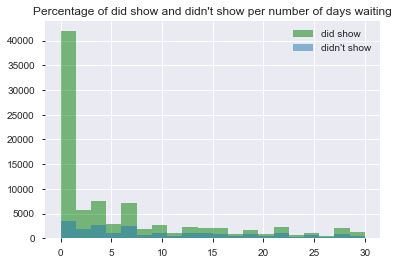

In [22]:
data.WaitingDay[did_show].hist(alpha=0.5,bins=20,label='did show',color='g')
data.WaitingDay[didnt_show].hist(alpha=0.5,bins=20,label="didn't show")
plt.legend()
plt.title("Percentage of did show and didn't show per number of days waiting")


If we look at the raw data, we a very low NoShow rate when there isn't any waiting day (surely because it's on the same day, so it's easier to come). And a slight increase until 10 waiting days is reached (0,32). So it would be interesting to segment this variable in this number of waiting days.

In [23]:
data.groupby('WaitingDay').NoShow.mean()

WaitingDay
0     0.052306
1     0.229757
2     0.246348
3     0.255012
4     0.255066
5     0.274239
6     0.257494
7     0.270398
8     0.289883
9     0.293416
10    0.323721
11    0.329188
12    0.310393
13    0.317610
14    0.317286
15    0.335333
16    0.304805
17    0.312936
18    0.311589
19    0.336759
20    0.346124
21    0.307497
22    0.343653
23    0.338170
24    0.385656
25    0.357065
26    0.356401
27    0.315929
28    0.294457
29    0.325518
30    0.273103
Name: NoShow, dtype: float64

As the variable "WaitingDay" gets its peak on 10-day waiting, I would like to segment this variable to have only 0-day waiting (which removes the biases observed before), before 10-day waiting and after 10-day waiting. This segmentation made the difference more visible.

In [24]:
bin_edges=[-1,0.1,9.9,31]
bin_names=["No waiting day",'1-9 waiting days','More than 10 waiting days']
data['Waiting_category'] = pd.cut(data['WaitingDay'], bin_edges, labels=bin_names)
data[data['WaitingDay']==0].head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow,Schedule,Appointment,Scheduled,AppointmentD,Waiting,WaitingDay,Waiting_category
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day


If we take the difference between "low" and "high" waiting days, and if we ignore 0 days waiting, we see that people who wait least than 10 days were 7 percent more to not showing up, which is an expected association.

In [25]:
data.groupby('Waiting_category').NoShow.mean()*100

Waiting_category
No waiting day                5.230550
1-9 waiting days             25.779680
More than 10 waiting days    32.320753
Name: NoShow, dtype: float64

In [26]:
data[['0 day','1-9 days','More than 9 days']]=pd.get_dummies(data['Waiting_category'])

According to P-Value, the associations between Waiting and No-Show are statistically significative.

In [27]:
data['intercept']=1
logit_model=sm.Logit(data['NoShow'],data[['intercept','0 day','More than 9 days']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.456035
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.093      
Dependent Variable: NoShow           AIC:              100814.4214
Date:               2020-01-21 16:39 BIC:              100843.2605
No. Observations:   110527           Log-Likelihood:   -50404.    
Df Model:           2                LL-Null:          -55603.    
Df Residuals:       110524           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept         -1.0575   0.0112 -94.5826 0.0000 -1.0794 -1.0355
0 day             -1.8395   0.0252 -72.8699 0.0000 -1

In [28]:
data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow,Schedule,Appointment,Scheduled,AppointmentD,Waiting,WaitingDay,Waiting_category,0 day,1-9 days,More than 9 days,intercept
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,False,2016-04-29,2016-04-29,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1


In [29]:
print(0.257797 *1.3749)

0.3544450953


### Can Appointment Month be associated with No-Show?
In order to see if No-Show is different according to the months, I created a Month variable from the AppointmentDay variable (the 6th and the 7th characters of this variable more precisely).

In [30]:
data['Month']=data['AppointmentDay'].str[5:7]
data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow,Schedule,...,Scheduled,AppointmentD,Waiting,WaitingDay,Waiting_category,0 day,1-9 days,More than 9 days,intercept,Month
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,False,2016-04-29,...,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1,04
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,False,2016-04-29,...,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1,04
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,False,2016-04-29,...,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1,04
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,False,2016-04-29,...,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1,04
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,False,2016-04-29,...,2016-04-29,2016-04-29,0 days,0,No waiting day,1,0,0,1,04


Here we see that only 3 months are in the data set, which makes the comparison less interesting.

In [31]:
data['Month'].groupby(data['Month']).value_counts()

Month  Month
04     04        3235
05     05       80841
06     06       26451
Name: Month, dtype: int64

Furthermore, there is less than 2% difference between each month.

In [32]:
data.groupby('Month').NoShow.mean()*100

Month
04    19.567233
05    20.786482
06    18.456769
Name: NoShow, dtype: float64

### 3) Can Day of Week be associated with No-Show?
In order to see if No-Show can differ with different days of the week, I've made this variable. As I already had a DateTime variable called "AppointmentD", I used it to get the day of the week. I've also sorted the labels as showed by this article (https://stackoverflow.com/questions/47741400/pandas-dataframe-group-and-sort-by-weekday?rq=1)

In [33]:
data['DayofWeek']=data['AppointmentD'].dt.day_name()
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

Here is the new variable per day of the week. We see there are more values for Tuesday and Wednesday (respectively 25640 and 25867), and fewer values for Saturday (39). No value is on Sunday, which is easily understandable because it's the free day of the week.

In [34]:
data['DayofWeek'].value_counts().reindex(days)

Monday       22715.0
Tuesday      25640.0
Wednesday    25867.0
Thursday     17247.0
Friday       19019.0
Saturday        39.0
Sunday           NaN
Name: DayofWeek, dtype: float64

In order to see the differences, I've designed a dashboard. We see that the difference by day of the week is less than 2% at the most. Saturday has more No-show percentage, but it can't make conclusions able as this value has only 39 observations.

In [35]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data.groupby(['DayofWeek']).NoShow.mean().reindex(cats) *100

DayofWeek
Monday       20.647149
Tuesday      20.093604
Wednesday    19.689179
Thursday     19.354091
Friday       21.226142
Saturday     23.076923
Sunday             NaN
Name: NoShow, dtype: float64

In [36]:
data[['Friday','Monday','Saturday','Thursday','Tuesday','Wednesday']]=pd.get_dummies(data['DayofWeek'])


In [37]:
data[data['DayofWeek']=='Saturday'].head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow,Schedule,...,More than 9 days,intercept,Month,DayofWeek,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
72295,F,2016-05-02T13:08:18Z,2016-05-14T00:00:00Z,60,0,0,0,1,False,2016-05-02,...,1,1,05,Saturday,0,0,1,0,0,0
72296,M,2016-05-12T16:13:24Z,2016-05-14T00:00:00Z,56,0,0,0,0,True,2016-05-12,...,0,1,05,Saturday,0,0,1,0,0,0
72297,F,2016-05-06T09:35:30Z,2016-05-14T00:00:00Z,27,1,0,0,1,False,2016-05-06,...,0,1,05,Saturday,0,0,1,0,0,0
72298,M,2016-05-02T12:02:42Z,2016-05-14T00:00:00Z,75,0,1,1,0,False,2016-05-02,...,1,1,05,Saturday,0,0,1,0,0,0
72299,F,2016-05-09T08:50:55Z,2016-05-14T00:00:00Z,67,0,0,0,1,False,2016-05-09,...,0,1,05,Saturday,0,0,1,0,0,0


According to the P Value, the days of the week aren't statistically significative. But another operations would be to try again by using another variables in the association.

In [38]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','Monday','Tuesday','Wednesday','Thursday','Friday']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.502946
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: NoShow           AIC:              111190.2131
Date:               2020-01-21 16:39 BIC:              111247.8911
No. Observations:   110527           Log-Likelihood:   -55589.    
Df Model:           5                LL-Null:          -55603.    
Df Residuals:       110521           LLR p-value:      4.7767e-05 
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept      -1.2040    0.3801  -3.1679  0.0015  -1.9489  -0.4591
Monday         -0.1424    0.3804  -0.3742  0.7082

### 4) Can SMS-received predict No-show
The next question is if an SMS is received, are there less No-showing Patients as they have a written message to remind them of the appointment. 29% of Patients who did show received an SMS, against 44% of patients who didn't show.

When an SMS had been received, 16,7% of Patients didn't show against 27,57% of Patients who didn't receive an SMS. It's a very strange association because we could expect exactly the opposite. The histogram confirms this association.

In [39]:
data.SMS_received[did_show].mean()*100

29.133411935425357

In [40]:
data.SMS_received[didnt_show].mean()*100

43.83708947533492

In [41]:
data.groupby('SMS_received').NoShow.mean()*100

SMS_received
0    16.703311
1    27.574545
Name: NoShow, dtype: float64

The dashboard below explains the difference between No SMS received and 1 SMS received. Effectively, it shows that there are many more values "didnt show".

Text(0.5, 1.0, "Percentage of did show and didn't show if a SMS has been received or not")

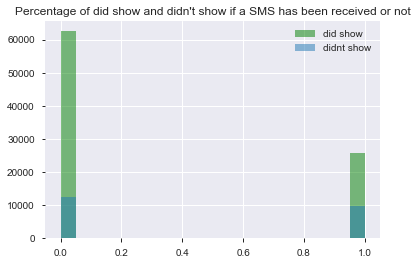

In [42]:
data.SMS_received[did_show].hist(alpha=0.5,bins=20,label='did show',color='g')
data.SMS_received[didnt_show].hist(alpha=0.5,bins=20,label='didnt show')
plt.legend()
plt.title("Percentage of did show and didn't show if a SMS has been received or not")

According to the P-Value, the association between No-Show and SMS Received is statistically significative.

In [43]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','SMS_received']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.495368
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.015      
Dependent Variable: NoShow           AIC:              109507.1700
Date:               2020-01-21 16:39 BIC:              109526.3960
No. Observations:   110527           Log-Likelihood:   -54752.    
Df Model:           1                LL-Null:          -55603.    
Df Residuals:       110525           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.6068   0.0098 -164.1868 0.0000 -1.6260 -1.5876
SMS_received      0.6411   0.0154   41.6555 0.0000  0

### 5) Is long waiting, SMS received and No-Show interrelated?

As it's less probable that people received an SMS if the Schedule Day was equal to the Appointment day, I wanted to see if this association was real. And it is a fact that people who haven't to wait a day have a low probability of receiving an SMS (1.1% against 42% between 2 and 9 days waiting, and 59,4% at least 10 days waiting).

In [44]:
data.groupby('Waiting_category').SMS_received.mean()*100

Waiting_category
No waiting day                1.157831
1-9 waiting days             42.095571
More than 10 waiting days    59.408135
Name: SMS_received, dtype: float64

And there is a strange association between SMS received, long waiting and No-Show:

1) No Waiting: an SMS received greatly improves the probability of not coming (28,5% against 4,9% when the Patients didn't get the SMS). Maybe we should also have gathered the content of the SMS or see in what context they have been sent.

2) Low Waiting: an SMS received hasn't a lot of difference (less than 0.5%)

3) High Waiting: an SMS received improves the showing up to 6.7% (29,6% of not showing when the Patients received an SMS against 36,3% when they received one).

In [45]:
data.groupby(['Waiting_category','SMS_received']).NoShow.mean()*100

Waiting_category           SMS_received
No waiting day             0                4.957871
                           1               28.508772
1-9 waiting days           0               25.934493
                           1               25.566729
More than 10 waiting days  0               36.334621
                           1               29.578192
Name: NoShow, dtype: float64

In this dashboard, we see all the paradox:
1) When there is no-day waiting, an SMS received increase greatly the probability that the Patient didn't show at the appointment.
2) When there are between 1 and 9 waiting days, there isn't a great difference.
3) When there are more than 10 waiting days, there is a slight improvement of people who didn't show when they received an SMS.

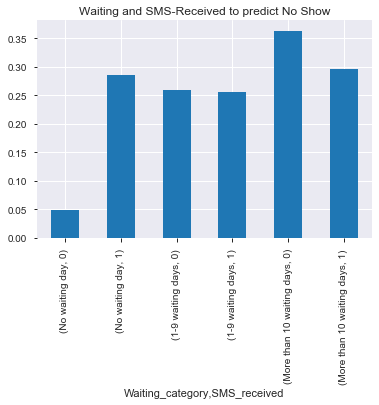

In [46]:
data.groupby(["Waiting_category","SMS_received"]).NoShow.mean().plot(kind='bar',title='Waiting and SMS-Received to predict No Show')

Every variable has aP-Value equal to 0 and is statistically associated to No-Show:

In [47]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','1-9 days','More than 9 days','SMS_received']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.455820
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.094      
Dependent Variable: NoShow           AIC:              100768.7963
Date:               2020-01-21 16:39 BIC:              100807.2484
No. Observations:   110527           Log-Likelihood:   -50380.    
Df Model:           3                LL-Null:          -55603.    
Df Residuals:       110523           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -2.8956   0.0226 -127.9379 0.0000 -2.9400 -2.8513
1-9 days          1.8864   0.0261   72.2249 0.0000  1

But the Pseudo R-Squared is pretty low: 0.094. I've tried by adding a new variable (0 day waiting and SMS received), but this new variable add only 0.3% to the explained variation.

In [48]:
data['SMS_No_waiting_day']=data['SMS_received']-3*data['1-9 days']-3*data['More than 9 days']
data['SMS_No_waiting_day']=data['SMS_No_waiting_day'].replace({-2:"No",-3:"No",0:"SMS_received_no_waiting_day",1:"No_SMS_received_Waiting_day"})


In [49]:
data[['No','SMS_received_NO_waiting_day','No_SMS_received_Waiting_day']]=pd.get_dummies(data['SMS_No_waiting_day'])

In [50]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','1-9 days','More than 9 days','SMS_received','SMS_received_NO_waiting_day']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.454501
         Iterations 7
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.097      
Dependent Variable:      NoShow              AIC:                 100479.3597
Date:                    2020-01-21 16:39    BIC:                 100527.4248
No. Observations:        110527              Log-Likelihood:      -50235.    
Df Model:                4                   LL-Null:             -55603.    
Df Residuals:            110522              LLR p-value:         0.0000     
Converged:               1.0000              Scale:               1.0000     
No. Iterations:          7.0000                                              
-----------------------------------------------------------------------------
                             Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

### 6) Can Scholarship predict No-show?
I assumed that Scholarship would lessen the probability of not showing because the Patients received government aid. But it was the opposite association. For low and high waiting, it was an improvement of respectively 6.6% and 7.2% of not showing at the appointment if the Patients received a governmental aid. It might be useful to see the association per revenue before making any conclusion

In [51]:
data.groupby('Scholarship').NoShow.mean()*100

Scholarship
0    19.807156
1    23.736304
Name: NoShow, dtype: float64

In [52]:
data.groupby(['Waiting_category','Scholarship']).NoShow.mean()*100

Waiting_category           Scholarship
No waiting day             0               5.068337
                           1               6.566604
1-9 waiting days           0              25.198194
                           1              31.737493
More than 10 waiting days  0              31.611976
                           1              38.832928
Name: NoShow, dtype: float64

We see all the differences in this dashboard. If we take No-day waiting, 0-9 waiting day or more than 10 waiting days, there are a little more of the probability of No-Show if the patient received Scholarship.

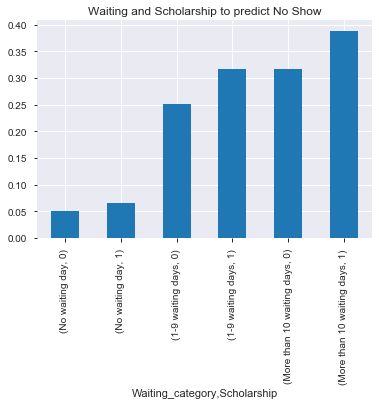

In [53]:
data.groupby(["Waiting_category","Scholarship"]).NoShow.mean().plot(kind='bar',title="Waiting and Scholarship to predict No Show")

According to the P-Value, Scholarship and Waiting days are all statistically associated to No-Show in medical appointments

In [54]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','1-9 days','More than 9 days','Scholarship']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.455363
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.095      
Dependent Variable: NoShow           AIC:              100667.7799
Date:               2020-01-21 16:39 BIC:              100706.2320
No. Observations:   110527           Log-Likelihood:   -50330.    
Df Model:           3                LL-Null:          -55603.    
Df Residuals:       110523           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -2.9354   0.0229 -128.1472 0.0000 -2.9803 -2.8905
1-9 days          1.8482   0.0253   73.1345 0.0000  1

### 7) Can Hypertension predict No-show?
Patients with Hypertension might go to the appointment as they have got a strong disease, and they might have more important needs.
In the data, Hypertension reduces from 3.6% to Patients who don't come to the appointment. But if we segment the data by No/low/high waiting, we can see that the association is stronger (about 6%).


In [55]:
data.groupby('Hipertension').NoShow.mean()*100

Hipertension
0    20.903681
1    17.301959
Name: NoShow, dtype: float64

In [56]:
data.groupby(['Waiting_category','Hipertension']).NoShow.mean()*100

Waiting_category           Hipertension
No waiting day             0                5.491596
                           1                4.001160
1-9 waiting days           0               27.064917
                           1               21.450214
More than 10 waiting days  0               33.488895
                           1               27.063016
Name: NoShow, dtype: float64

We see this difference in this dashboard. If we compare No-day waiting, between 1 and 9 days waiting and more than 10 days waiting, there is more probability of No-Show if the patient has Hypertension.

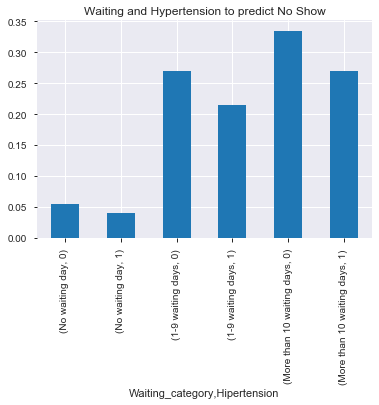

In [57]:
data.groupby(["Waiting_category","Hipertension"]).NoShow.mean().plot(kind='bar', title="Waiting and Hypertension to predict No Show")

According to the P-Value, Hipertension and Waiting Days are statistically associated to No-Show in medical appointments

In [58]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','1-9 days','More than 9 days','Hipertension']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.454965
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.096      
Dependent Variable: NoShow           AIC:              100579.8432
Date:               2020-01-21 16:39 BIC:              100618.2953
No. Observations:   110527           Log-Likelihood:   -50286.    
Df Model:           3                LL-Null:          -55603.    
Df Residuals:       110523           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -2.8487   0.0228 -124.8634 0.0000 -2.8934 -2.8040
1-9 days          1.8578   0.0253   73.4595 0.0000  1

###  8) Can Gender be associated with NoShow
I wasn't sure if there could be a difference of No-Show, so I took the means to discover there wasn't any difference (less than 0.1%).

In [59]:
data.groupby('Gender').NoShow.mean()*100

Gender
F    20.314588
M    19.967948
Name: NoShow, dtype: float64

In [60]:
data.groupby(['Waiting_category','Gender']).NoShow.mean()*100

Waiting_category           Gender
No waiting day             F          4.431083
                           M          6.516125
1-9 waiting days           F         25.810636
                           M         25.718554
More than 10 waiting days  F         32.089288
                           M         32.801679
Name: NoShow, dtype: float64

In [61]:
data[['Women','Men']]=pd.get_dummies(data['Gender'])

According to the P-Value, gender and waiting days are statistically associated to No-Show medical appointments

In [62]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','0 day','1-9 days','Men']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.455969
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.094      
Dependent Variable: NoShow           AIC:              100801.8167
Date:               2020-01-21 16:39 BIC:              100840.2688
No. Observations:   110527           Log-Likelihood:   -50397.    
Df Model:           3                LL-Null:          -55603.    
Df Residuals:       110523           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -0.7597    0.0136  -55.7973  0.0000  -0.7864  -0.7330
0 day         -2.1618    0.0259  -83.5579  0.0000

###  9) Can Age predict No-show: 
There wasn't any clear difference when we took the age of Patients who did show up and the Patients who didn't show up. The cumulative histogram wasn't clear either.

In [63]:
data.Age[did_show].describe()

count    88208.000000
mean        37.790064
std         23.338878
min         -1.000000
25%         18.000000
50%         38.000000
75%         56.000000
max        115.000000
Name: Age, dtype: float64

We see in this diagram that there are always more did show than didn't show for every value of Age and it's some similarity between “did show” and “didn't show” for every value of Age.

Text(0.5, 1.0, "Distribution of did show and didn't show per age")

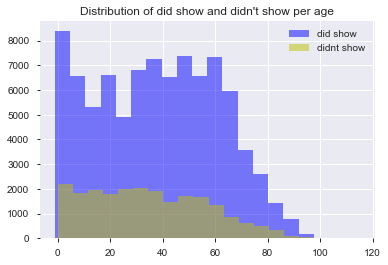

In [64]:
data.Age[did_show].hist(alpha=0.5,bins=20,label='did show',color='b')
data.Age[didnt_show].hist(alpha=0.5,bins=20,label='didnt show',color='y')
plt.legend()
plt.title("Distribution of did show and didn't show per age")

So I cut the ages first to get the 0-10 and the 11-20 categories, then I got each 20 years segment into the age.

In [65]:
bin_edges=[-1,10,20,30,40,50,60,70,80,150]
bin_names=["0-10 years old","11-20 year old","21-30 years old","31-40 years old","41-50 years old","51-60 years old","61-70 years old","71-80 years old","After 80 years old"]
data['Age_segment'] = pd.cut(data['Age'], bin_edges, labels=bin_names)
data[data['Age']==51].head()

,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,SMS_received,NoShow,Schedule,...,Thursday,Tuesday,Wednesday,SMS_No_waiting_day,No,SMS_received_NO_waiting_day,No_SMS_received_Waiting_day,Women,Men,Age_segment
28,M,2016-04-29T15:48:02Z,2016-04-29T00:00:00Z,51,0,0,0,0,False,2016-04-29,...,0,0,0,SMS_received_no_waiting_day,0,0,1,0,1,51-60 years old
98,F,2016-04-12T09:44:42Z,2016-04-29T00:00:00Z,51,0,0,0,1,False,2016-04-12,...,0,0,0,No,1,0,0,1,0,51-60 years old
105,M,2016-04-29T09:02:40Z,2016-04-29T00:00:00Z,51,0,1,0,0,False,2016-04-29,...,0,0,0,SMS_received_no_waiting_day,0,0,1,0,1,51-60 years old
269,F,2016-04-29T12:13:58Z,2016-04-29T00:00:00Z,51,0,0,0,0,False,2016-04-29,...,0,0,0,SMS_received_no_waiting_day,0,0,1,1,0,51-60 years old
272,F,2016-04-18T10:12:57Z,2016-04-29T00:00:00Z,51,0,1,0,1,True,2016-04-18,...,0,0,0,No,1,0,0,1,0,51-60 years old


There is a big difference between "11-20 years old" and "61-70 years old" (25,2% of not showing up against 14,72% of not showing up).

In [66]:
data.groupby('Age_segment').NoShow.mean()

Age_segment
0-10 years old        0.202037
11-20 year old        0.252538
21-30 years old       0.246245
31-40 years old       0.214722
41-50 years old       0.199029
51-60 years old       0.173744
61-70 years old       0.147288
71-80 years old       0.155392
After 80 years old    0.164446
Name: NoShow, dtype: float64

In this dashboard, we see that 0-10 has less No-Show proportion than 11-20 years old. Maybe 0-10 years old children are accompanied by parents. After that, the percentage of No-Show is much higher, and it gets lower and lower until 70 years old when it gets more and more a little higher.

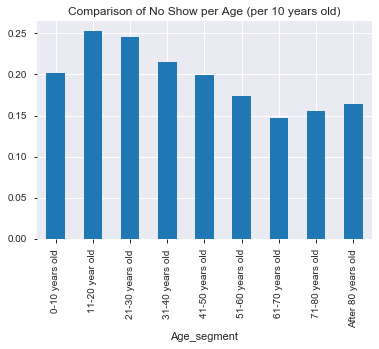

In [67]:
data.groupby('Age_segment').NoShow.mean().plot(kind='bar', title="Comparison of No Show per Age (per 10 years old)")

In [68]:
data[['0-10 years-old','11-20 years old','21-30 years old','31-40 years old','41-50 years old','51-60 years old','61-70 years old','71-80 years old','After 80 years old']]=pd.get_dummies(data['Age_segment'])

According to the P-Value, every age category is statistically different from 10 years old and under, except from 41-50 (maybe because the values are somewhat similar between 0-10 years old and 41-50 years old).

In [69]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','11-20 years old','21-30 years old','31-40 years old','41-50 years old','51-60 years old','61-70 years old','71-80 years old','After 80 years old']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.499522
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.007      
Dependent Variable:  NoShow           AIC:              110439.3939
Date:                2020-01-21 16:39 BIC:              110525.9110
No. Observations:    110527           Log-Likelihood:   -55211.    
Df Model:            8                LL-Null:          -55603.    
Df Residuals:        110518           LLR p-value:      5.1921e-164
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      6.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
intercept          -1.3737   0.0182 -75.5237 0.0000 -1.4093 -1.3380
11-20 years old     0.2886   0.0271  10.6

### General logistic regression

I've tried to test very statistically significant variable in a big logistic regression. Every value was statistically different from control one, except from Hypertension and 41-50 years old (Hypertension might be an intermediate variable and 41-50 years old was already non statistically significant.

In [70]:
logit_model=sm.Logit(data['NoShow'],data[['intercept','1-9 days','More than 9 days','SMS_received','SMS_received_NO_waiting_day','Scholarship','Hipertension','Men','11-20 years old','21-30 years old','31-40 years old','41-50 years old','51-60 years old','61-70 years old','71-80 years old','After 80 years old']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.448916
         Iterations 7
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.108     
Dependent Variable:      NoShow              AIC:                 99266.6378
Date:                    2020-01-21 16:39    BIC:                 99420.4461
No. Observations:        110527              Log-Likelihood:      -49617.   
Df Model:                15                  LL-Null:             -55603.   
Df Residuals:            110511              LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          7.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
inter

## Conclusions
I took my Pandas and Matplotlib codes from the Project Walkthrough, the Pandas and Matplotlib documentation, and the website Stack Overflow (https://stackoverflow.com). It was only coded documentation, so I didn’t refer to the provenance of my code.
### Results
I can conclude several things from the data: 1) One of the biggest differences was 0 waiting day from the rest: 5,2% of Not Showing against 25,8% for “1–9 days”, and 32,3% for “after 10 days. So more the patient has to wait, more there is a probability of not showing up.


2) There isn’t any significative difference of No Show if we take different months or days of the week.


3) There is a strange association of SMS-received: if an SMS is received when there is no waiting day, the probability of not showing improves from 5% to 28,5%. But we don’t know the content of the SMS itself.

4) The SMS received variable impacts only when the number of waiting days are 10 or above (from 36,3% of not showing to 29,5% when an SMS is received).

5) Patients who have Hypertension tend more to show up (more than 6% when there is one waiting day or more).

6) There wasn’t a big Gender difference for showing up or not showing up (less than 0.6%)

7) After 10 years old, there is a negative association between age and not showing up, which disappears after about 71 years old (which can be for a difficulty to move). 25,2% of Patients between 11–20 years old don’t show up against 14,7% aged from 61 to 70.
### Limitations

1) The biggest problem is we don’t know why Patients don’t show up, so we can’t make a strong conclusion about why there are these differences.

2) The content of the SMS in the “SMS_received” is also missing.

3) We don’t have any variables like “difficulty to move”,”urgency of the problem”,”income” and “distance”. These variables that could explain our findings.

However, the discovered associations can clearly show some associations of who tends to show up and who don’t, and a beginning of explanation can be made from our data.

Lots of reasons might explain why the logistic regression didn't give a good pseudo R-Square. I will test machine learning technics in the future.

